## 安裝OpenAI gymnasium 環境

In [1]:
!unzip -o data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.7 MB/s eta 0:00:00


In [ ]:
from time import time
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import os
import pandas as pd

## 設定交易環境
此處為設定遊戲規則的程式碼，**此處程式碼不可更改**


In [ ]:
class Actions(Enum):
    Buy_NTD = 0
    Buy_S1 = 1
    Buy_S2 = 2
    Buy_S3 = 3
    Buy_S4 = 4
    Buy_S5 = 5
    Buy_S6 = 6
    Buy_S7 = 7
    Buy_S8 = 8

class Positions(Enum):
    # 代表持有幣別
    NTD = 0
    S1 = 1
    S2 = 2
    S3 = 3
    S4 = 4
    S5 = 5
    S6 = 6
    S7 = 7
    S8 = 8

    def opposite(self,action):
      return Positions(action)

In [ ]:
class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df_list, window_size, render_mode=None):
        # assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.df_list = df_list

        self.render_mode = render_mode
        self.window_size = window_size
        self.prices_list, self.signal_features_list = self._process_data()
        self.shape = (window_size, self.signal_features_list[0].shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices_list[0]) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None

        self._last_position = None
        self._action = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))
        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.NTD
        self._position_history = (self.window_size * [None]) + [self._position]
        self._action = 0
        self._total_reward = 0.
        self._total_profit = 10000.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._action = action
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False

        if action != self._position.value:
            trade = True

        if trade:
            self._last_position = self._position
            self._position = self._position.opposite(action)
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        observation = []
        for i in range(len(self.signal_features_list)):
          observation.extend(self.signal_features_list[i][self._current_tick-self.window_size:self._current_tick])
        return np.array(observation, dtype=np.float32)

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def choice_price_col(self, position, buy_or_sell="buy"):
        col_name = 'open' if buy_or_sell == "buy" else 'close'

        foreign_price = None
        if position == Positions.S1:
          foreign_price = self.prices_list[0][col_name].to_numpy()
        elif position == Positions.S2:
          foreign_price = self.prices_list[1][col_name].to_numpy()
        elif position == Positions.S3:
          foreign_price = self.prices_list[2][col_name].to_numpy()
        elif position == Positions.S4:
          foreign_price = self.prices_list[3][col_name].to_numpy()
        elif position == Positions.S5:
          foreign_price = self.prices_list[4][col_name].to_numpy()
        elif position == Positions.S6:
          foreign_price = self.prices_list[5][col_name].to_numpy()
        elif position == Positions.S7:
          foreign_price = self.prices_list[6][col_name].to_numpy()
        elif position == Positions.S8:
          foreign_price = self.prices_list[7][col_name].to_numpy()
        return foreign_price


    def render(self, mode='human'):

        def _plot_position():
            # 有買賣
            if self._action != self._position.value:

              # 現在不是持有台幣(即有買入股票)
              if self._position != Positions.NTD:
                # 買入用紅色
                buy_price_col = self.choice_price_col(self._position)
                plt.scatter(self._current_tick, buy_price_col[self._current_tick], color='red')

              # 上一步不是持有台幣(即有賣出股票)
              if self._last_position != Positions.NTD:
                # 賣出用綠色
                sell_price_col = self.choice_price_col(self._last_position)
                plt.scatter(self._current_tick, sell_price_col[self._current_tick], color='green')
        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices_list[0]['open'].to_numpy(), label="S1")
            plt.plot(self.prices_list[1]['open'].to_numpy(), label="S2")
            plt.plot(self.prices_list[2]['open'].to_numpy(), label="S3")
            plt.plot(self.prices_list[3]['open'].to_numpy(), label="S4")
            plt.plot(self.prices_list[4]['open'].to_numpy(), label="S5")
            plt.plot(self.prices_list[5]['open'].to_numpy(), label="S6")
            plt.plot(self.prices_list[6]['open'].to_numpy(), label="S7")
            plt.plot(self.prices_list[7]['open'].to_numpy(), label="S8")
            # plt.yscale('log')
            plt.legend(bbox_to_anchor=(1.0, 1.0))

            # 起始點標藍色
            plt.scatter(self._current_tick, self.prices_list[0]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[1]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[2]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[3]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[4]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[5]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[6]['open'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices_list[7]['open'].to_numpy()[self._current_tick], color='blue')

        _plot_position()

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Fund: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)


    def render_all(self, title=None):

        plt.cla()
        plt.plot(self.prices_list[0]['open'].to_numpy(), label="S1")
        plt.plot(self.prices_list[1]['open'].to_numpy(), label="S2")
        plt.plot(self.prices_list[2]['open'].to_numpy(), label="S3")
        plt.plot(self.prices_list[3]['open'].to_numpy(), label="S4")
        plt.plot(self.prices_list[4]['open'].to_numpy(), label="S5")
        plt.plot(self.prices_list[5]['open'].to_numpy(), label="S6")
        plt.plot(self.prices_list[6]['open'].to_numpy(), label="S7")
        plt.plot(self.prices_list[7]['open'].to_numpy(), label="S8")
        plt.legend(bbox_to_anchor=(1.0, 1.0))

        last_positions = Positions.NTD

        for i, position in enumerate(self._position_history):
          if position != None:
            # 有買賣
            if position != last_positions:
              # 現在不是持有台幣(即有買入股票)
              if position != Positions.NTD:
                price_col = self.choice_price_col(position)
                plt.scatter(i, price_col[i], color='red')

              # 上一步不是持有台幣(即有賣出股票)
              if last_positions != Positions.NTD:
                price_col = self.choice_price_col(last_positions)
                plt.scatter(i, price_col[i], color='green')

              last_positions = self._position_history[i]

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Fund: %.6f" % self._total_profit
        )

    def render_hold(self, title=None):
        plt.cla()

        # 使用天數作為橫軸
        days = range(len(self._position_history))
        y = self._position_history
        y = [yi.value if yi is not None else 0 for yi in y]
        # y = y.append(y[-1])
        plt.step(days, y)
        plt.xlabel('Day')
        plt.ylabel('Position')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Fund: %.6f" % self._total_profit
        )

        # 顯示圖形
        plt.show()


    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError


In [ ]:
class StockEnv(TradingEnv):

    def __init__(self, df_list, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        self.handing_charge = 0.001425
        self.transaction_tex = 0.0030
        super().__init__(df_list, window_size, render_mode)

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):

        # 有交易
        if action != self._position.value:
          # 原本非台幣
          if self._position != Positions.NTD:
            # 此處賣出為銀行方，等於投資者的買入
            buy_price_col = self.choice_price_col(self._position, "sell")
            buy_price = buy_price_col[self._last_trade_tick]

            # 此處買入為銀行方，等於投資者的賣出
            sell_price_col = self.choice_price_col(self._position, "buy")
            sell_price = sell_price_col[self._current_tick]

            self._total_profit *= (1-self.handing_charge) #買手續費
            self._total_profit = (self._total_profit / buy_price) * sell_price
            self._total_profit *= (1-self.handing_charge) #賣手續費

        # 結束
        if self._truncated:
          if action != Actions.Buy_NTD.value:
            buy_price_col = self.choice_price_col(Positions(action), "sell")
            buy_price = buy_price_col[self._last_trade_tick]


            sell_price_col = self.choice_price_col(Positions(action), "buy")
            sell_price = sell_price_col[self._current_tick]

            self._total_profit *= (1-self.handing_charge) #買手續費
            self._total_profit = (self._total_profit / buy_price) * sell_price
            self._total_profit *= (1-self.handing_charge-self.transaction_tex) #賣手續費

    def get_total_profit(self):
      return self._total_profit


## 設定 seed

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)

## 使用訓練資料集

In [ ]:
def load_stock_data(csv_file)->list:
    df = pd.read_csv(csv_file)
    stock_list = ['A','B','C','D','E','F','G','H']
    price_list = []
    for stock_id in stock_list:
        price_list.append(df[df['stock_id']==stock_id])

    return price_list

In [ ]:
import pandas as pd
origin_df_list = load_stock_data('./data/train_data.csv')
origin_df_list[0]

,id,date,stock_id,close,open,high,low,volume,ht_dcperiod,ht_dcphase,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
0,0,1,A,37.09,40.49,40.49,36.99,11014263,18.935218,218.894999,...,-0.010615,0.872362,38.573956,0.761016,2.347224,6.328454,3.5,1.323104e+08,-4.765308e+06,68524199.0
8,8,2,A,38.76,41.06,41.16,38.56,6184351,18.525203,244.370592,...,-0.068000,0.814459,38.317143,0.663344,2.488167,6.419420,2.6,1.348056e+08,-3.468964e+06,70067949.0
16,16,3,A,37.13,38.33,39.13,36.03,32584957,18.182184,271.172984,...,-0.118703,1.003721,37.820440,1.007456,2.531870,6.818932,3.1,1.253455e+08,-6.417927e+06,37482992.0
24,24,4,A,37.18,36.38,38.08,36.28,14415132,17.878844,291.990007,...,-0.084000,0.884375,37.801429,0.782120,2.479593,6.669159,1.8,1.253455e+08,-7.040873e+06,51898124.0
32,32,5,A,36.03,37.73,38.53,35.53,15210752,17.684413,-44.430682,...,-0.145077,1.133197,37.155495,1.284136,2.516765,6.985193,3.0,1.152050e+08,-9.882159e+06,36687372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14856,14856,1858,A,77.37,77.47,77.97,76.87,4941814,18.765551,79.868887,...,0.065231,0.368944,77.729231,0.136120,1.475342,1.906866,1.1,5.857503e+08,9.796692e+06,155887563.0
14864,14864,1859,A,78.45,78.35,78.45,77.85,6246837,18.472341,130.637560,...,0.119824,0.434953,78.281538,0.189184,1.401188,1.786090,0.6,5.974397e+08,1.177923e+07,168566536.0
14872,14872,1860,A,79.70,78.60,80.00,78.30,12112190,18.260519,145.560157,...,0.163516,0.847679,78.823516,0.718560,1.422531,1.784858,1.7,6.052770e+08,1.373830e+07,180678726.0
14880,14880,1861,A,79.11,79.91,79.91,78.31,7411579,18.008176,156.381269,...,0.171560,0.813299,79.068132,0.661456,1.435208,1.814193,1.6,6.052770e+08,1.329080e+07,173267147.0


## 自定義環境
將股票資料輸入交易環境，並設定本次環境範圍與輸入天數資料 (欄位內容、天數等)。


In [ ]:
def my_calculate_reward(self, action):
    """
    可以修改此function，更改reward設計
    """
    step_reward = 0
    if self._position == Positions.NTD:
      step_reward = 0

    else:
      price_col = self.choice_price_col(self._position)
      current_price = price_col[self._current_tick]
      last_day_price = price_col[self._current_tick-1]
      step_reward = (current_price - last_day_price) / last_day_price
    return step_reward

def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]

    prices_list, signal_features_list = [], []

    used_columns = [
      "close","open","high","low","volume","ht_dcperiod","ht_dcphase","inphase","quadrature","sine","leadsine","adx","adxr","apo","aroondown","aroonup","aroonosc","bop","cci","cmo","dx","macd_x","macdsignal_x","macdhist_x","macd_y","macdsignal_y","macdhist_y","macd","macdsignal","macdhist","mfi","minus_di","minus_dm","mom","plus_di","plus_dm","ppo","roc","rocp","rocr","rocr100","rsi","slowk","slowd","fastk_x","fastd_x","fastk_y","fastd_y","trix","ultosc","willr","upperband","middleband","lowerband","dema","ema","ht_trendline","kama","ma","mama","fama","midpoint","midprice","sar","sarext","sma","t3","tema","trima","wma","avgprice","medprice","typprice","wclprice","beta","correl","linearreg","linearreg_angle","linearreg_intercept","linearreg_slope","stddev","tsf","var","atr","natr","trange","ad","adosc","obv"
    ]

    for df in env.df_list:
      prices_list.append(df.iloc[start:end, :].filter(['open','close']))
      # 這邊可修改想要使用的 feature
      # signal_features_list.append(df.iloc[:,2:].to_numpy()[start:end])
      signal_features_list.append(df.filter(used_columns).to_numpy()[start:end])

    return prices_list, signal_features_list

class MyStockEnv(StockEnv):
    # 除 _process_data 和 _calculate_reward 外，其餘功能 (class function) 禁止覆寫
    _process_data = my_process_data
    _calculate_reward = my_calculate_reward

# window_size: 能夠看到幾天的資料當作輸入, frame_bound: 想要使用的資料日期區間
# 可修改 frame_bound 來學習不同的環境資料，frame_bound起始值必須>=window_size
# 不可修改此處 window_size 參數 ，最後計算分數時 window_size 也會設為10
env = MyStockEnv(origin_df_list, window_size=10, frame_bound=(1000, 1800))

## 檢視環境參數

env information:
> env.shape: (10, 89)
> df.shape: (1862, 92)
> prices.shape: (810, 2)
> signal_features.shape: (810, 89)


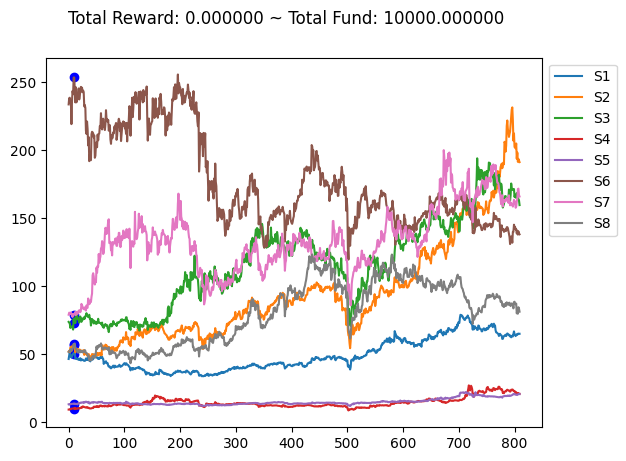

In [ ]:
print("env information:")
print("> env.shape:", env.shape)
print("> df.shape:", env.df_list[0].shape)
print("> prices.shape:", env.prices_list[0].shape)
print("> signal_features.shape:", env.signal_features_list[0].shape)

env.reset()
env.render()

未訓練情況下，隨機跑一個EPISODE

{'total_reward': 0.8961524083723853, 'total_profit': 6230.7714076359725, 'position': <Positions.S8: 8>}


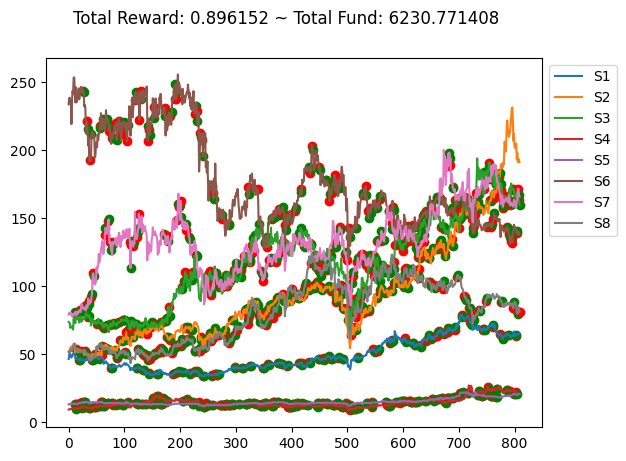

In [ ]:
observation = env.reset()

while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print(info)
        break

env.render_all()
plt.show()

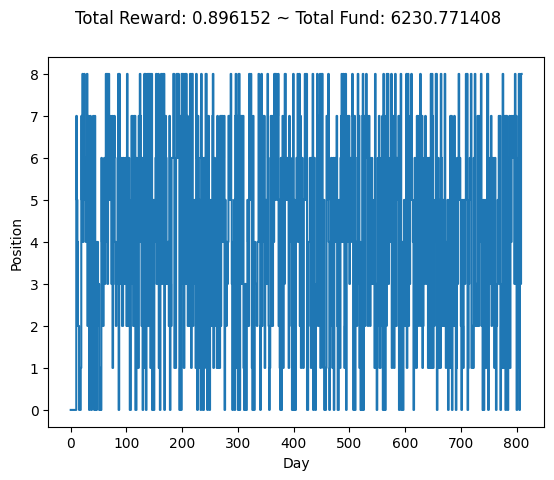

In [ ]:
env.render_hold()
plt.show()

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入shape是 (8, window_size = 10, 91) 的 observation，輸出則是離散的9個動作之一 (即Actions)

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim*8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 9)


    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。 這個 agent 能做到以下幾件事：


*   learn()：從記下來的 log probabilities 及 rewards 來更新 policy network。
*   sample()：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。 而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [ ]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        state = state.flatten()
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()

        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def load_ckpt(self, ckpt_path):
      if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        self.network.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      else:
        print("Checkpoint file not found, use default settings")

    def save_ckpt(self, ckpt_path):
      torch.save({
            'model_state_dict': self.network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, ckpt_path)

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [ ]:
network = PolicyGradientNetwork(env.shape[0] * env.shape[1])
agent = PolicyGradientAgent(network)

## 訓練 Agent
現在我們開始訓練 agent。 透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在資料日期區間結束後，回放這些「記憶」來訓練 policy network。

In [ ]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 200     # 總共更新 200 次
CHECKPOINT_PATH = './model.ckpt' # agent model 儲存位置

avg_total_rewards = []

agent.network.train()  # 訓練前，先確保 network 處在 training 模式

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards = []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        observation, _ = env.reset()
        total_step = 0
        while True:
            action, log_prob = agent.sample(observation)
            observation, reward, done, info = env.step(action)
            log_probs.append(log_prob)
            total_step += 1
            if done:
              total_rewards.append(info['total_reward'])
              # 設定同一個 episode 每個 action 的 reward 都是 total reward，這邊可以更改你們覺得合理的Cumulated rewards方式
              rewards.append(np.full(total_step, info['total_reward']))
              break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_total_rewards.append(avg_total_reward)
    prg_bar.set_description(f"Average Reward: {avg_total_reward: 4.2f}, Final Reward: {info['total_reward']: 4.2f}, Final Profit: {info['total_profit']: 4.2f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

# 儲存 agent model 參數
agent.save_ckpt(CHECKPOINT_PATH)

  0%|          | 0/200 [00:00<?, ?it/s]

## 訓練結果
訓練過程中，我們持續記下了 avg_total_reward，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。 理論上，若是 agent 一直在進步，則所得到的 avg_total_reward 也會持續上升。 若將其畫出來則結果如下：

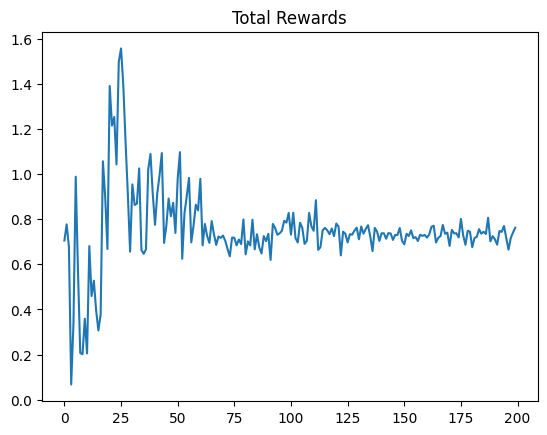

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

## 測試
在這邊我們可以替換環境使用的資料日期區間，並使用讀取紀錄點的方式來執行測試。

<ipython-input-15-8fe1505959e1>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


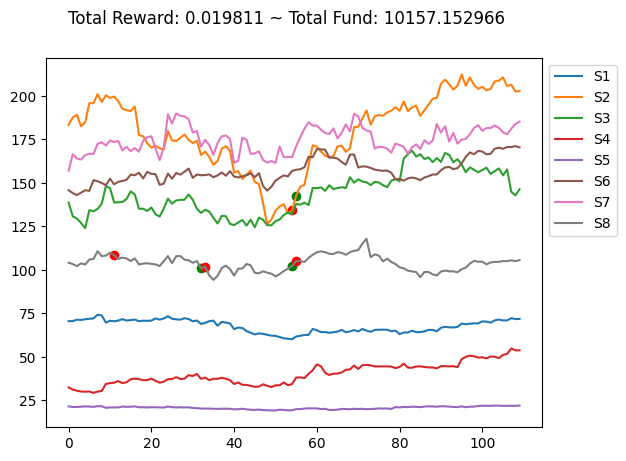

In [ ]:
test_df = load_stock_data('./data/test_data.csv')
env = MyStockEnv(df_list=test_df, window_size=10, frame_bound=(100, 200))

network = PolicyGradientNetwork(env.shape[0] * env.shape[1])
test_agent = PolicyGradientAgent(network)

checkpoint_path = './model.ckpt'

test_agent.load_ckpt(checkpoint_path)
test_agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

observation,_ = env.reset()
while True:
    action, _ = test_agent.sample(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break

env.render_all()
plt.show()

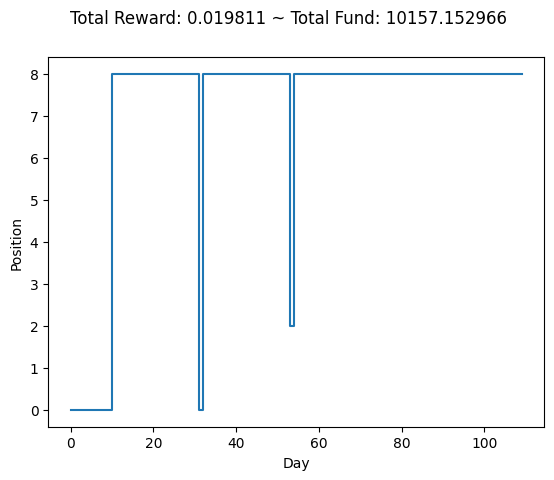

In [ ]:
env.render_hold()
plt.show()


## Score
請確認可以正確載入test data，並成功執行
到時候我們會更換成private test data用來打分

In [ ]:
private_df = load_stock_data('./data/private_test_data.csv')
private_df[0]

FileNotFoundError: [Errno 2] No such file or directory: './data/private_test_data.csv'

In [ ]:
frame_bounds = [(10,50), (10,100), (10,200)]
mean_profit = 0

for frame_bound in frame_bounds:
  env = MyForexEnv(df_list=private_df, window_size=10, frame_bound=frame_bound)
  # env.reset()
  # env.render_all()

  network = PolicyGradientNetwork(env.shape[0] * env.shape[1])
  test_agent = PolicyGradientAgent(network)

  checkpoint_path = './model.ckpt'

  test_agent.load_ckpt(checkpoint_path)
  test_agent.network.eval()

  # 我們會跑10次取平均
  for i in range(10):
    observation,_ = env.reset()
    while True:
        action, _ = test_agent.sample(observation)
        observation, reward, done, info = env.step(action)
        if done:
          break

    # env.render_all()
    # plt.show()

    mean_profit += env.get_total_profit()

mean_profit /= (10 * len(frame_bounds))
print("Score:", mean_profit)